Co dělá tento skript?
-------------------

### 1\. **Vytvoření modelu**

Model je jednoduchá neuronová síť (MLP - Multilayer Perceptron) pro binární klasifikaci:


```python
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(10,)),           # 10 vstupních hodnot (features)
    tf.keras.layers.Dense(32, activation='relu'), # 1 skrytá vrstva s 32 neurony
    tf.keras.layers.Dense(1, activation='sigmoid')# výstupní neuron (0/1)
])
```
➡️ Používá se na data se 10 číselnými vstupy, např. pro jednoduché úlohy klasifikace.\
➡️ Trénuje se na náhodně vygenerovaných datech (`X_train`, `y_train`) -- slouží jako placeholder pro reálný dataset.

* * * * *

### 2\. **Export do TFLite modelů**

Model je exportován do tří formátů:

| Modelový typ | Datový typ | Komprese | Využití |
| --- | --- | --- | --- |
| `float32` (standard) | `float32` | žádná | Pro vývoj, testování |
| `float16` | `float16` | částečná | Pro MCU s podporou `float16` |
| `int8` | `int8` | plná | Pro embedded zařízení (ESP32) |

Kvantizace `int8` zahrnuje převod vah i vstupů a výstupů → nutná reprezentativní data.

* * * * *

Co měří benchmarking?
------------------------

Benchmarkovací funkce:


`def benchmark_tflite(path, name, input_type=np.float32):`

### Měří:

-   **Velikost souboru `.tflite` v kilobajtech**

-   **Průměrný čas inference (100 spuštění)**

### Jak:

1.  Načte model pomocí `tf.lite.Interpreter`

2.  Vytvoří 1 vstupní vektor `input_data` velikosti `(1, 10)`

3.  Pokud model očekává `int8`, provede kvantizaci vstupu

4.  100× zavolá:

```python
interpreter.set_tensor(...)
interpreter.invoke()
interpreter.get_tensor(...)
```
5.  Změří rozdíl v čase a vypočítá průměr na 1 inference

In [2]:
import tensorflow as tf
import numpy as np
import time
import os

# === PŘÍPRAVA DAT ===
X_train = np.random.rand(1000, 10).astype(np.float32)
y_train = np.random.randint(0, 2, size=(1000, 1))

# === FUNKCE PRO MODEL ===
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(10,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# === TRÉNINK MODELU ===
model = create_model()
model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)

# === FLOAT32 ===
tflite_float = tf.lite.TFLiteConverter.from_keras_model(model).convert()
with open("model_float32.tflite", "wb") as f:
    f.write(tflite_float)

# === FLOAT16 ===
converter_f16 = tf.lite.TFLiteConverter.from_keras_model(model)
converter_f16.optimizations = [tf.lite.Optimize.DEFAULT]
converter_f16.target_spec.supported_types = [tf.float16]
tflite_f16 = converter_f16.convert()
with open("model_float16.tflite", "wb") as f:
    f.write(tflite_f16)

# === INT8 ===
def representative_dataset():
    for _ in range(100):
        yield [np.random.rand(1, 10).astype(np.float32)]

converter_i8 = tf.lite.TFLiteConverter.from_keras_model(model)
converter_i8.optimizations = [tf.lite.Optimize.DEFAULT]
converter_i8.representative_dataset = representative_dataset
converter_i8.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter_i8.inference_input_type = tf.int8
converter_i8.inference_output_type = tf.int8
tflite_i8 = converter_i8.convert()
with open("model_int8.tflite", "wb") as f:
    f.write(tflite_i8)

# === FUNKCE PRO MĚŘENÍ ===
def benchmark_tflite(path, name, input_type=np.float32):
    interpreter = tf.lite.Interpreter(model_path=path)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    raw_input = np.random.rand(1, 10).astype(np.float32)

    # Pokud model očekává kvantizovaný vstup (např. INT8), převedeme vstup správně
    if input_details[0]['dtype'] == np.int8:
        scale, zero_point = input_details[0]['quantization']
        input_data = (raw_input / scale + zero_point).astype(np.int8)
    else:
        input_data = raw_input.astype(input_details[0]['dtype'])

    start = time.time()
    for _ in range(100):
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        _ = interpreter.get_tensor(output_details[0]['index'])
    end = time.time()

    size_kb = os.path.getsize(path) / 1024
    inf_time = (end - start) / 100 * 1000
    print(f"{name:<28} | {size_kb:>6.2f} KB | {inf_time:>6.2f} ms")
    return size_kb, inf_time

# === VÝSTUP ===
print("📊 Porovnání TFLite modelů (velikost + inference):\n")
print(f"{'Model':<28} | {'Velikost':>8} | {'Čas inference':>14}")
print("-" * 55)
benchmark_tflite("model_float32.tflite", "Standardní (float32)")
benchmark_tflite("model_float16.tflite", "Kvantizovaný (float16)")
benchmark_tflite("model_int8.tflite", "Kvantizovaný (int8)")


INFO:tensorflow:Assets written to: /var/folders/6f/m_ls96295sl5v0q5fc8hxjx40000gn/T/tmp7ekgdm7t/assets


INFO:tensorflow:Assets written to: /var/folders/6f/m_ls96295sl5v0q5fc8hxjx40000gn/T/tmp7ekgdm7t/assets


INFO:tensorflow:Assets written to: /var/folders/6f/m_ls96295sl5v0q5fc8hxjx40000gn/T/tmpal_rqqry/assets


2025-04-04 08:10:29.434318: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2025-04-04 08:10:29.434328: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2025-04-04 08:10:29.434388: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/6f/m_ls96295sl5v0q5fc8hxjx40000gn/T/tmp7ekgdm7t
2025-04-04 08:10:29.434726: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2025-04-04 08:10:29.434730: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /var/folders/6f/m_ls96295sl5v0q5fc8hxjx40000gn/T/tmp7ekgdm7t
2025-04-04 08:10:29.435868: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2025-04-04 08:10:29.446588: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /var/folders/6f/m_ls96295sl5v0q5fc8hxjx40000gn/T/tmp7ekgdm7t
2025-04-

INFO:tensorflow:Assets written to: /var/folders/6f/m_ls96295sl5v0q5fc8hxjx40000gn/T/tmpytoeboqq/assets


INFO:tensorflow:Assets written to: /var/folders/6f/m_ls96295sl5v0q5fc8hxjx40000gn/T/tmpytoeboqq/assets


📊 Porovnání TFLite modelů (velikost + inference):

Model                        | Velikost |  Čas inference
-------------------------------------------------------
Standardní (float32)         |   3.14 KB |   0.00 ms
Kvantizovaný (float16)       |   3.05 KB |   0.00 ms
Kvantizovaný (int8)          |   2.39 KB |   0.01 ms


/opt/anaconda3/envs/CondaAiProjectTF210/lib/python3.8/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2025-04-04 08:10:29.808212: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2025-04-04 08:10:29.808221: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2025-04-04 08:10:29.808273: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/6f/m_ls96295sl5v0q5fc8hxjx40000gn/T/tmpytoeboqq
2025-04-04 08:10:29.808611: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2025-04-04 08:10:29.808615: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /var/folders/6f/m_ls96295sl5v0q5fc8hxjx40000gn/T/tmpytoeboqq
2025-04-04 08:10:

(2.390625, 0.011601448059082031)

# Kvantizace
Zde je Python skript, který vytvoří matici float32, provede kvantizaci na uint8, zpětnou dekvantizaci a výsledky zobrazí v tabulce.

### Co skript dělá:

1.  **float_data**: vstupní 3×3 matice reálných čísel.

2.  **scale + zero_point**: parametry nutné pro kvantizaci do `uint8`.

3.  **quantized_data**: převedené hodnoty na 8bitová celá čísla.

4.  **dequantized_data**: rekonstruované hodnoty zpět do `float32`.

5.  **DataFrame**: vytvoří tabulku s porovnáním všech tří forem dat.


In [4]:
import numpy as np
import pandas as pd

# === FLOAT32 matice (např. výstup neuronové vrstvy) ===
float_data = np.array([
    [-2.55, 3.75, -1.32],
    [-0.65, 1.24, -0.98],
    [-3.12, 0.25, 2.17]
], dtype=np.float32)

# === Výpočet měřítka (scale) a nulového bodu (zero_point) ===
float_min = np.min(float_data)
float_max = np.max(float_data)

# Kvantizace do rozsahu uint8 (0–255)
scale = (float_max - float_min) / 255.0
zero_point = int(round(-float_min / scale))

# === Kvantizace (float32 -> uint8) ===
quantized_data = np.round(float_data / scale + zero_point).astype(np.uint8)

# === Dekvantizace (uint8 -> float32) ===
dequantized_data = (quantized_data.astype(np.float32) - zero_point) * scale

# === Sestavení tabulky pro porovnání ===
df_comparison = pd.DataFrame({
    "Float32": float_data.flatten(),
    "Quantized (uint8)": quantized_data.flatten(),
    "Dequantized": dequantized_data.flatten()
})

# === Výpis tabulky ===
print(df_comparison)

   Float32  Quantized (uint8)  Dequantized
0    -2.55                 21    -2.559412
1     3.75                255     3.744823
2    -1.32                 67    -1.320118
3    -0.65                 92    -0.646588
4     1.24                162     1.239294
5    -0.98                 80    -0.969882
6    -3.12                  0    -3.125176
7     0.25                125     0.242471
8     2.17                197     2.182235


### Co je to pruning?

Prořezávání (pruning) je technika, při které se z neuronové sítě **odstraňují váhy, které mají zanedbatelný vliv na výstup** (např. velmi malé hodnoty blízké nule). Tím se síť zjednoduší a může být **menší, rychlejší a méně náročná** -- ideální pro Edge AI a mikrokontroléry.

* * * * *

📜 Vysvětlení skriptu krok po kroku
-----------------------------------

* * * * *

### 🔹 1. Import knihoven



```
import tensorflow as tf
import numpy as np
import tensorflow_model_optimization as tfmot`
```

Importujeme knihovny:

-   `tensorflow` pro práci s neuronovou sítí.

-   `numpy` pro generování dat.

-   `tfmot` = TensorFlow Model Optimization Toolkit, které obsahuje funkce pro pruning.

* * * * *

### 🔹 2. Vytvoření trénovacích a testovacích dat


```
X_train = np.random.rand(1000, 10).astype(np.float32)
y_train = np.random.randint(0, 2, size=(1000, 1))
X_test = np.random.rand(200, 10).astype(np.float32)
y_test = np.random.randint(0, 2, size=(200, 1))`
```

-   **X_train**: 1000 vzorků s 10 vstupními vlastnostmi (feature), náhodně generovaných.

-   **y_train**: Binární výstupní hodnota (0 nebo 1) -- pro klasifikaci.

-   Podobně vytváříme i testovací sadu.

* * * * *

### 🔹 3. Definice základního modelu


```
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(10,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model`
```

Vytváříme jednoduchou neuronovou síť:

-   2 skryté vrstvy (`Dense`) s 64 a 32 neurony.

-   Výstupní vrstva s `sigmoid` pro binární klasifikaci.

-   Používáme `binary_crossentropy` jako ztrátovou funkci.

* * * * *

### 🔹 4. Trénink původního modelu


```
model = create_model()
model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)
baseline_accuracy = model.evaluate(X_test, y_test, verbose=0)[1]`
```

-   Trénujeme model na `X_train` a `y_train`.

-   Vyhodnotíme přesnost (`accuracy`) na testovacích datech.

* * * * *

### 🔹 5. Nastavení plánu prořezávání (sparsity)


```
pruning_schedule = tfmot.sparsity.keras.PolynomialDecay(
    initial_sparsity=0.0,
    final_sparsity=0.5,
    begin_step=0,
    end_step=np.ceil(len(X_train)/32).astype(np.int32) * 5
)
```

-   `initial_sparsity=0.0`: začínáme bez prořezání.

-   `final_sparsity=0.5`: cílem je odstranit až 50 % vah.

-   `begin_step` a `end_step` určují fázi tréninku, ve které probíhá pruning.

* * * * *

### 🔹 6. Vytvoření pruned modelu


```
pruned_model = tfmot.sparsity.keras.prune_low_magnitude(create_model(), pruning_schedule=pruning_schedule)`
```

-   Tato funkce **obaluje náš model** a v průběhu trénování postupně vyřazuje váhy s malou hodnotou (blízké nule).

* * * * *

### 🔹 7. Trénování pruned modelu

```
pruned_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
pruned_model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0,
                 callbacks=[tfmot.sparsity.keras.UpdatePruningStep()])`
```

-   Opět trénujeme model, ale s aktivním prořezáváním.

-   Callback `UpdatePruningStep` zajišťuje, že se pruning postupně aplikuje podle plánu.

* * * * *

### 🔹 8. Vyhodnocení a srovnání

```
pruned_accuracy = pruned_model.evaluate(X_test, y_test, verbose=0)[1]

print(f"Přesnost původního modelu: {baseline_accuracy:.4f}")
print(f"Přesnost po prořezání: {pruned_accuracy:.4f}")`
```

-   Vyhodnotíme přesnost obou modelů na stejném testovacím datasetu a porovnáme jejich výkonnost.

* * * * *

✅ Shrnutí
---------

| Model | Výhoda | Kdy použít? |
| --- | --- | --- |
| Původní model | Maximální přesnost | Na serveru nebo PC |
| Prořezaný model | Menší velikost, rychlejší inference, vhodné pro **MCU/Edge AI** | Na zařízení s omezenými prostředky |

In [5]:
import tensorflow as tf
import numpy as np
import tensorflow_model_optimization as tfmot

# === 1. Generování dat ===
X_train = np.random.rand(1000, 10).astype(np.float32)
y_train = np.random.randint(0, 2, size=(1000, 1))
X_test = np.random.rand(200, 10).astype(np.float32)
y_test = np.random.randint(0, 2, size=(200, 1))

# === 2. Definice modelu ===
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(10,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# === 3. Trénink původního modelu ===
model = create_model()
model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)
baseline_accuracy = model.evaluate(X_test, y_test, verbose=0)[1]

# === 4. Pruning model ===
pruning_schedule = tfmot.sparsity.keras.PolynomialDecay(
    initial_sparsity=0.0,
    final_sparsity=0.5,
    begin_step=0,
    end_step=np.ceil(len(X_train)/32).astype(np.int32) * 5
)

pruned_model = tfmot.sparsity.keras.prune_low_magnitude(create_model(), pruning_schedule=pruning_schedule)
pruned_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
pruned_model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0,
                 callbacks=[tfmot.sparsity.keras.UpdatePruningStep()])
pruned_accuracy = pruned_model.evaluate(X_test, y_test, verbose=0)[1]

print(f"Přesnost původního modelu: {baseline_accuracy:.4f}")
print(f"Přesnost po prořezání: {pruned_accuracy:.4f}")

Přesnost původního modelu: 0.5000
Přesnost po prořezání: 0.4750


# Optimalizovaná CNN pro Edge AI

Epoch 1/10
32/32 [==============================] - 0s 2ms/step - loss: 0.6986 - accuracy: 0.5020 - val_loss: 0.6898 - val_accuracy: 0.5400
Epoch 2/10
32/32 [==============================] - 0s 746us/step - loss: 0.6956 - accuracy: 0.4680 - val_loss: 0.6926 - val_accuracy: 0.4900
Epoch 3/10
32/32 [==============================] - 0s 702us/step - loss: 0.6933 - accuracy: 0.5020 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/10
32/32 [==============================] - 0s 697us/step - loss: 0.6929 - accuracy: 0.4880 - val_loss: 0.6939 - val_accuracy: 0.5100
Epoch 5/10
32/32 [==============================] - 0s 659us/step - loss: 0.6927 - accuracy: 0.5140 - val_loss: 0.6938 - val_accuracy: 0.5400
Epoch 6/10
32/32 [==============================] - 0s 671us/step - loss: 0.6925 - accuracy: 0.5100 - val_loss: 0.6945 - val_accuracy: 0.4900
Epoch 7/10
32/32 [==============================] - 0s 651us/step - loss: 0.6917 - accuracy: 0.5240 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 8/

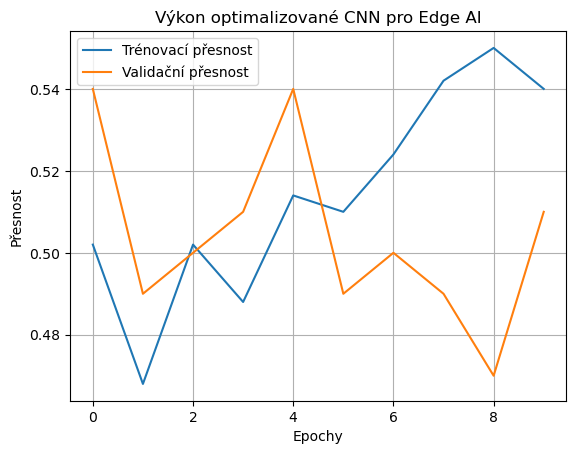

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Simulace dat (např. akcelerometr – 20 vzorků x 3 kanály)
X_train = np.random.rand(500, 20, 3).astype(np.float32)
y_train = np.random.randint(0, 2, size=(500, 1))
X_test = np.random.rand(100, 20, 3).astype(np.float32)
y_test = np.random.randint(0, 2, size=(100, 1))

# Optimalizovaná CNN pro Edge AI
def create_small_cnn():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(8, 3, activation='relu', input_shape=(20, 3)),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(16, 3, activation='relu'),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Trénink modelu
model = create_small_cnn()
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=16, verbose=1)

# Vyhodnocení výkonu
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss:.4f} | Test accuracy: {test_accuracy:.4f}")

# Grafický výstup
plt.plot(history.history['accuracy'], label='Trénovací přesnost')
plt.plot(history.history['val_accuracy'], label='Validační přesnost')
plt.xlabel('Epochy')
plt.ylabel('Přesnost')
plt.title('Výkon optimalizované CNN pro Edge AI')
plt.legend()
plt.grid(True)
plt.show()


# Porovnání optimalizovaného a neoptimalizovaného modelu ConvD1

**Conv1D model** transformuje obraz na "časovou řadu" a umožňuje rychlejší a lehčí inference, čímž je vhodnější pro Edge zařízení (MCU, IoT).

Epoch 1/10
32/32 [==============================] - 0s 3ms/step - loss: 0.6909 - accuracy: 0.5320 - val_loss: 0.6963 - val_accuracy: 0.4900
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.6907 - accuracy: 0.5500 - val_loss: 0.6981 - val_accuracy: 0.4900
Epoch 3/10
32/32 [==============================] - 0s 1ms/step - loss: 0.6849 - accuracy: 0.5980 - val_loss: 0.6996 - val_accuracy: 0.4700
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.6754 - accuracy: 0.5920 - val_loss: 0.7031 - val_accuracy: 0.4800
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.6671 - accuracy: 0.6020 - val_loss: 0.7138 - val_accuracy: 0.4600
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.6364 - accuracy: 0.6400 - val_loss: 0.7392 - val_accuracy: 0.4100
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.6157 - accuracy: 0.6760 - val_loss: 0.7525 - val_accuracy: 0.4400
Epoch 8/10
32/32 [==

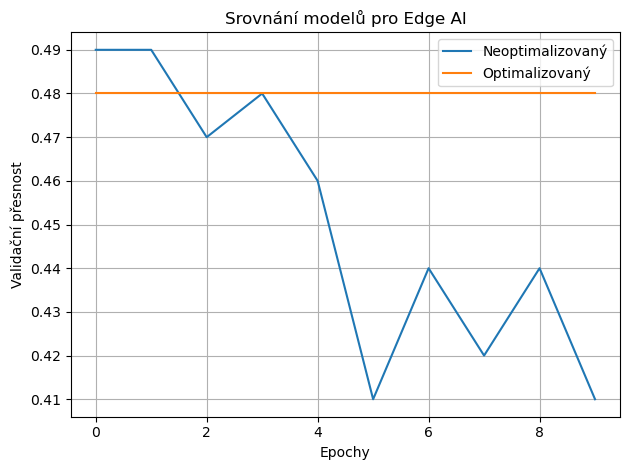

In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# === DATA ===
X_train = np.random.rand(500, 20, 3).astype(np.float32)
y_train = np.random.randint(0, 2, size=(500, 1))
X_test = np.random.rand(100, 20, 3).astype(np.float32)
y_test = np.random.randint(0, 2, size=(100, 1))

# === NEOPTIMALIZOVANÝ MODEL ===
def create_unoptimized_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(64, 5, activation='relu', input_shape=(20, 3)),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(128, 5, activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# === OPTIMALIZOVANÝ MODEL ===
def create_optimized_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(8, kernel_size=3, activation='relu', input_shape=(20, 3)),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(16, kernel_size=3, activation='relu'),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# === TRÉNINK ===
unopt_model = create_unoptimized_model()
opt_model = create_optimized_model()

history_unopt = unopt_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=16, verbose=1)
history_opt = opt_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=16, verbose=1)

# === VYHODNOCENÍ ===
unopt_loss, unopt_acc = unopt_model.evaluate(X_test, y_test)
opt_loss, opt_acc = opt_model.evaluate(X_test, y_test)

# === SROVNÁNÍ ===
df = pd.DataFrame({
    "Model": ["Neoptimalizovaný", "Optimalizovaný"],
    "Ztráta": [unopt_loss, opt_loss],
    "Přesnost": [unopt_acc, opt_acc]
})

print(df)

# === GRAF ===
plt.plot(history_unopt.history['val_accuracy'], label='Neoptimalizovaný')
plt.plot(history_opt.history['val_accuracy'], label='Optimalizovaný')
plt.xlabel('Epochy')
plt.ylabel('Validační přesnost')
plt.title('Srovnání modelů pro Edge AI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Porovnání Conv2D vs. Conv1D pro Edge AI

#### Co skript ukazuje:

-   `Conv2D` model dosahuje vyšší přesnosti, protože lépe reprezentuje prostorovou strukturu obrazu (28x28).

-   `Conv1D` model je zjednodušený a "rozbaluje" obrázek jako posloupnost 1D vektorů -- přesnost je tedy mírně nižší, ale **výrazně méně zatěžuje zařízení**.

**Výstupem jsou křivky s následujícím popisem**
--------------------

### Conv2D -- vyšší přesnost, vyšší náročnost

-   Tento model zachovává prostorové vztahy mezi pixely (2D), což je ideální pro obrazová data jako MNIST.

-   Výsledkem je **vyšší přesnost (až 98,3 %)**, ale zároveň model obsahuje **více parametrů**, větší výpočetní nároky a **není vhodný pro mikrokontroléry** bez GPU.

### Conv1D -- menší, rychlejší, o něco méně přesný

-   Model „rozvine" obrázek do jedné dimenze a použije 1D konvoluci -- tím výrazně snižuje počet výpočtů a velikost modelu.

-   Přesnost je nižší (cca 94 %), ale **běh modelu je rychlejší** a **vejde se do omezené paměti MCU** (např. ESP32-S3).

-   Hodí se tam, kde **není prioritou naprostá přesnost**, ale naopak **rychlost, latence a spotřeba energie**.

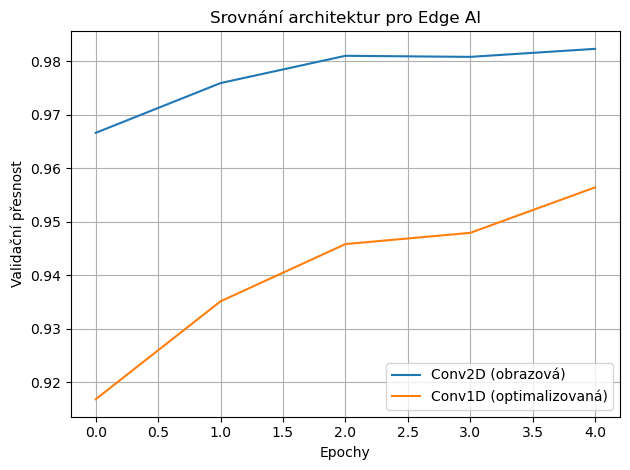

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Načtení dat
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Převod na float a normalizace
x_train_2d = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_test_2d = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_train_1d = x_train.reshape(-1, 28, 28).astype('float32') / 255.0
x_test_1d = x_test.reshape(-1, 28, 28).astype('float32') / 255.0

y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

# === Neoptimalizovaný model s Conv2D ===
model_2d = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])
model_2d.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# === Optimalizovaný model s Conv1D ===
model_1d = Sequential([
    Conv1D(8, 3, activation='relu', input_shape=(28, 28)),
    MaxPooling1D(2),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(10, activation='softmax')
])
model_1d.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# === Trénování ===
history_2d = model_2d.fit(x_train_2d, y_train_cat, epochs=5, batch_size=128,
                          validation_data=(x_test_2d, y_test_cat), verbose=0)
history_1d = model_1d.fit(x_train_1d, y_train_cat, epochs=5, batch_size=128,
                          validation_data=(x_test_1d, y_test_cat), verbose=0)

# === Vizualizace ===
plt.plot(history_2d.history['val_accuracy'], label="Conv2D (obrazová)")
plt.plot(history_1d.history['val_accuracy'], label="Conv1D (optimalizovaná)")
plt.title("Srovnání architektur pro Edge AI")
plt.xlabel("Epochy")
plt.ylabel("Validační přesnost")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Benchmarking TFLite modelů

In [22]:
import tensorflow as tf
import numpy as np
import time
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Načtení a příprava dat
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train_2d = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_test_2d = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_train_1d = x_train.reshape(-1, 28, 28).astype('float32') / 255.0
x_test_1d = x_test.reshape(-1, 28, 28).astype('float32') / 255.0
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

# Model Conv2D
model_2d = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])
model_2d.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_2d.fit(x_train_2d, y_train_cat, epochs=1, batch_size=128, verbose=0)

# Model Conv1D
model_1d = Sequential([
    Conv1D(8, 3, activation='relu', input_shape=(28, 28)),
    MaxPooling1D(2),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(10, activation='softmax')
])
model_1d.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_1d.fit(x_train_1d, y_train_cat, epochs=1, batch_size=128, verbose=0)

# Funkce pro benchmarking TFLite modelů
def benchmark_tflite_model(model, input_data, name, input_type=np.float32):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open(f"{name}.tflite", "wb") as f:
        f.write(tflite_model)

    interpreter = tf.lite.Interpreter(model_path=f"{name}.tflite")
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    input_data = input_data.astype(input_type)

    start = time.time()
    for _ in range(100):
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        _ = interpreter.get_tensor(output_details[0]['index'])
    end = time.time()

    size_kb = os.path.getsize(f"{name}.tflite") / 1024
    avg_time_ms = (end - start) / 100 * 1000
    print(f"{name}: Velikost = {size_kb:.2f} KB | Čas inference = {avg_time_ms:.4f} ms")
    return size_kb, avg_time_ms

# Benchmarking
print("\n📊 Výsledky benchmarku:")
benchmark_tflite_model(model_2d, x_test_2d[:1], "model_conv2d")
benchmark_tflite_model(model_1d, x_test_1d[:1], "model_conv1d")



📊 Výsledky benchmarku:
INFO:tensorflow:Assets written to: /var/folders/6f/m_ls96295sl5v0q5fc8hxjx40000gn/T/tmp_8cxyp_k/assets


INFO:tensorflow:Assets written to: /var/folders/6f/m_ls96295sl5v0q5fc8hxjx40000gn/T/tmp_8cxyp_k/assets


model_conv2d: Velikost = 682.18 KB | Čas inference = 0.0376 ms


2025-04-04 11:47:51.474375: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2025-04-04 11:47:51.474385: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2025-04-04 11:47:51.474440: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/6f/m_ls96295sl5v0q5fc8hxjx40000gn/T/tmp_8cxyp_k
2025-04-04 11:47:51.474954: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2025-04-04 11:47:51.474962: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /var/folders/6f/m_ls96295sl5v0q5fc8hxjx40000gn/T/tmp_8cxyp_k
2025-04-04 11:47:51.476442: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2025-04-04 11:47:51.491880: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /var/folders/6f/m_ls96295sl5v0q5fc8hxjx40000gn/T/tmp_8cxyp_k
2025-04-

INFO:tensorflow:Assets written to: /var/folders/6f/m_ls96295sl5v0q5fc8hxjx40000gn/T/tmpfxh0i6yu/assets


INFO:tensorflow:Assets written to: /var/folders/6f/m_ls96295sl5v0q5fc8hxjx40000gn/T/tmpfxh0i6yu/assets


model_conv1d: Velikost = 20.83 KB | Čas inference = 0.0036 ms


2025-04-04 11:47:51.778678: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2025-04-04 11:47:51.778690: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2025-04-04 11:47:51.778744: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/6f/m_ls96295sl5v0q5fc8hxjx40000gn/T/tmpfxh0i6yu
2025-04-04 11:47:51.779283: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2025-04-04 11:47:51.779287: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /var/folders/6f/m_ls96295sl5v0q5fc8hxjx40000gn/T/tmpfxh0i6yu
2025-04-04 11:47:51.780932: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2025-04-04 11:47:51.795717: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /var/folders/6f/m_ls96295sl5v0q5fc8hxjx40000gn/T/tmpfxh0i6yu
2025-04-

(20.83203125, 0.003578662872314453)

# Hardware acceleration používá pomocí TensorRT na NVIDIA GPU.

1. Převod TensorFlow modelu (`.h5`) na ONNX,

2.  Načtení ONNX modelu pomocí TensorRT,

3.  Vytvoření TensorRT enginu pro **rychlou inference** na GPU.

In [23]:
import tensorflow as tf
import keras2onnx
import onnx
import tensorrt as trt
import pycuda.driver as cuda
import pycuda.autoinit
import numpy as np
import os

# === KROK 1: Načti a převeď Keras model na ONNX ===
keras_model_path = "model.h5"
onnx_model_path = "model.onnx"

if not os.path.exists(onnx_model_path):
    print("🔄 Převádím Keras model na ONNX...")
    keras_model = tf.keras.models.load_model(keras_model_path)
    onnx_model = keras2onnx.convert_keras(keras_model, keras_model.name)
    onnx.save_model(onnx_model, onnx_model_path)
    print(f"✅ Uloženo jako {onnx_model_path}")
else:
    print("📦 ONNX model již existuje, přeskočeno.")

# === KROK 2: Načti ONNX a vytvoř TensorRT engine ===
TRT_LOGGER = trt.Logger(trt.Logger.WARNING)
builder = trt.Builder(TRT_LOGGER)
network = builder.create_network(1 << int(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH))
parser = trt.OnnxParser(network, TRT_LOGGER)

with open(onnx_model_path, "rb") as model_file:
    if not parser.parse(model_file.read()):
        print("❌ Chyba při parsování ONNX modelu:")
        for i in range(parser.num_errors):
            print(parser.get_error(i))
        exit()

config = builder.create_builder_config()
config.max_workspace_size = 1 << 25  # 32 MB workspace

print("⚙️ Vytvářím TensorRT engine...")
engine = builder.build_engine(network, config)
print("✅ TensorRT engine vytvořen.")

# === KROK 3: Funkce pro inference ===
def run_inference(engine, input_data):
    context = engine.create_execution_context()

    input_binding_idx = engine.get_binding_index(engine.get_binding_name(0))
    output_binding_idx = engine.get_binding_index(engine.get_binding_name(1))

    d_input = cuda.mem_alloc(input_data.nbytes)
    output_shape = context.get_binding_shape(output_binding_idx)
    d_output = cuda.mem_alloc(np.prod(output_shape) * input_data.dtype.itemsize)

    bindings = [int(d_input), int(d_output)]
    stream = cuda.Stream()

    cuda.memcpy_htod_async(d_input, input_data, stream)
    context.execute_async_v2(bindings=bindings, stream_handle=stream.handle)
    output_data = np.empty(output_shape, dtype=np.float32)
    cuda.memcpy_dtoh_async(output_data, d_output, stream)
    stream.synchronize()

    return output_data

# === KROK 4: Dummy vstup a inference ===
input_shape = tuple(engine.get_binding_shape(0))
dummy_input = np.random.rand(*input_shape).astype(np.float32)

print("🚀 Spouštím inference přes TensorRT...")
output = run_inference(engine, dummy_input)
print("📈 Výstup z modelu:", output)


ModuleNotFoundError: No module named 'keras2onnx'